## Vehicle Price Estimator

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import joblib
import ipywidgets as widgets
from ipywidgets import interact, interactive, interact_manual, interactive_output, fixed
from ydata_profiling import ProfileReport
from sklearn.model_selection import train_test_split, GridSearchCV
from math import sqrt
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
%matplotlib inline

### This application uses machine learning to predict the selling price of vehicles as far back as 1990. You can use this information as a tool when  negotiating with customers or acquiring new inventory. To begin, run the next cell to load the model. 

In [3]:
# Load the model, encoder, and data.
model = joblib.load('lgb_model.pkl')
ordinal_encoder = joblib.load('label_encoders.pkl')
df = pd.read_csv("vehicles_cleaned.csv")

### Running the following cell will prompt you for information on the vehicle you are enquiring about. This software can't be used for rare or uncommon vehicles.

In [4]:
# Variables to hold unique values from the dataset
select_year = sorted((df['year'] + 1900).unique())
select_condition = df['condition'].unique()
select_transmission = df['transmission'].unique()
select_manufacturers = sorted(df['manufacturer'].unique())

# Setup Dropdowns
d_manufacturer = widgets.Dropdown(options=select_manufacturers, description='Make:')
d_model = widgets.Dropdown(options=[], description='Model:')
d_year = widgets.Dropdown(options=select_year, description='Model Year: ')
d_condition = widgets.Dropdown(options=select_condition, description='Condition: ')
d_transmission = widgets.Dropdown(options=select_transmission, description='Transmission: ')

# Define update function
def update_model_options(*args):
    selected_manufacturer = d_manufacturer.value
    filtered_df = df[df['manufacturer'] == selected_manufacturer]
    models = sorted(filtered_df['model'].unique())
    d_model.options = models

# Observe changes
d_manufacturer.observe(update_model_options, 'value')

# Initialize
update_model_options()

# Display

while True:
    # Prompt the user to type in mileage
    mileage_str = input("Please enter the mileage: ")

    try:
        # Convert the input to an integer
        mileage = int(mileage_str)
        
        # Check if the mileage is within the valid range
        if 0 <= mileage <= 300000:
            break  # Exit the loop if the mileage is valid
        else:
            print("Mileage must be between 0 and 300,000.")
    except ValueError:
        print("Invalid input. Please enter a valid integer.")

# Print the valid mileage entered by the user
print("Entered mileage ", mileage)


display(d_year, d_manufacturer, d_model, d_condition, d_transmission)

Please enter the mileage:  125000


Entered mileage  125000


Dropdown(description='Model Year: ', options=(1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000…

Dropdown(description='Make:', options=('acura', 'alfa-romeo', 'aston-martin', 'audi', 'bmw', 'buick', 'cadilla…

Dropdown(description='Model:', options=('2002 rsx type s', '3.0cl', '3.2 cl type s', '3.2 tl', '3.2 tl- type s…

Dropdown(description='Condition: ', options=('good', 'excellent', 'fair', 'like new', 'new', 'salvage'), value…

Dropdown(description='Transmission: ', options=('other', 'automatic', 'manual'), value='other')

### Once you've entered the vehicle's information, run the following cell to generate your sale price prediction. Run the above cell again to make a prediction for a different vehicle. 

In [5]:
# Preprocess user input
user_input = pd.DataFrame({
    'manufacturer': [d_manufacturer.value],
    'model': [d_model.value],
    'condition': [d_condition.value],
    'transmission': [d_transmission.value]
})
year = d_year.value - 1900

# Encode categorical features
user_input_encoded = ordinal_encoder.transform(user_input)

# Extract individual encoded values
manufacturer_encoded = user_input_encoded[0][0]
model_encoded = user_input_encoded[0][1]
condition_encoded = user_input_encoded[0][2]
transmission_encoded = user_input_encoded[0][3]


# Create a DataFrame with the preprocessed input
user_input_df = pd.DataFrame({
    'year': [year],
    'manufacturer': [manufacturer_encoded],
    'model': [model_encoded],
    'condition': [condition_encoded],
    'odometer': [mileage // 10000],  # Round odometer to nearest 10000
    'transmission': [transmission_encoded], 
})

# Make prediction
predicted_price = model.predict(user_input_df)[0]
predicted_price = round(predicted_price)

# Display the predicted price
print(f"The predicted selling price for this vehicle is ${predicted_price}")

The predicted selling price for this vehicle is $5993


### Chart for most popular makes. Ford and Chevrolet make up a large portion of the used car market. 

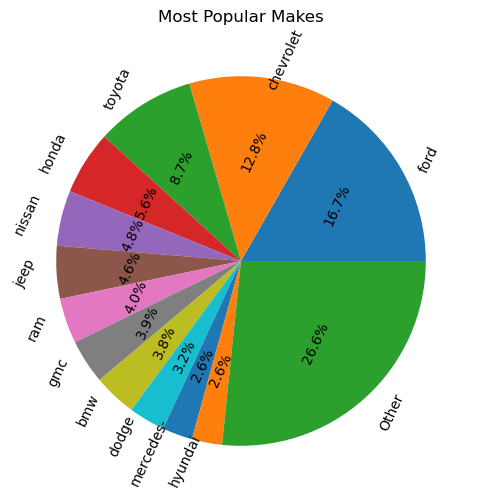

In [50]:
# Show most popular cars sold by manufacturer
manufacturer_counts = df['manufacturer'].value_counts()

#Preparing the chart
top_n = 12
top_manufacturers = manufacturer_counts.head(12)
other_count = manufacturer_counts.iloc[top_n:].sum()
top_manufacturers['Other'] = other_count
max_label_length = 9
top_manufacturers.index = [label[:max_label_length] if len(label) > max_label_length else label for label in top_manufacturers.index]

#Plotting the chart
plt.figure(figsize=(6, 6))
plt.pie(top_manufacturers, labels=top_manufacturers.index, autopct='%1.1f%%', textprops={'rotation': 65})
plt.title('Most Popular Makes')
plt.show()


### The correlation matrix shows a vehicle's model year and mielage have the greatest effect on the price. A newer vehicle with lower miles tends to sell for a higher price.

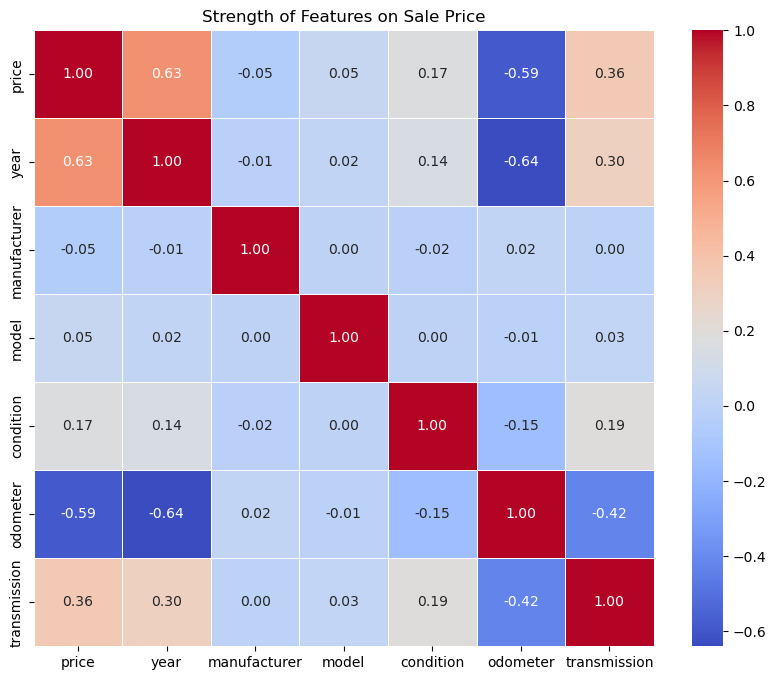

In [51]:
# Prepare the data for the matrix
matrix_df = df.copy()
cat_cols = ['manufacturer', 'model', 'condition', 'transmission']
ordinal_encoder = OrdinalEncoder()
matrix_df[cat_cols] = ordinal_encoder.fit_transform(matrix_df[cat_cols])

# Calculate the correlation matrix
correlation_matrix = matrix_df.corr()

# Plotting the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Strength of Features on Sale Price')
plt.show()


### The bar chart shows which make sells for the highest average price. The only Ferraris and Land Rovers represented in the data are older, higher mileage, and poor condition examples. Because of this they appear towards the low end of the chart.

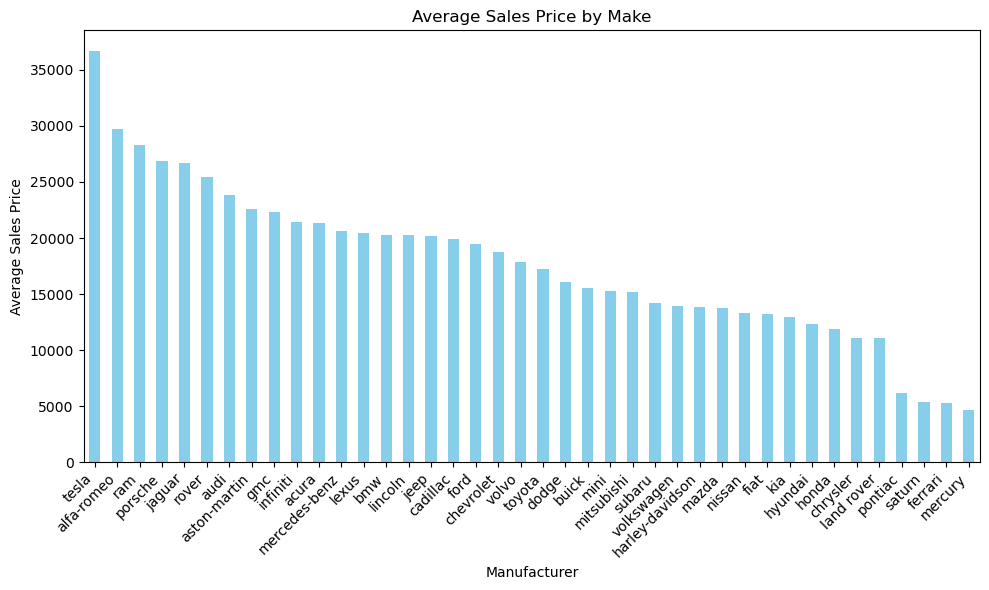

In [52]:
# Calculate average sales price for each manufacturer
average_prices = df.groupby('manufacturer')['price'].mean().sort_values(ascending=False)

# Plotting the bar chart
plt.figure(figsize=(10, 6))
average_prices.plot(kind='bar', color='skyblue')
plt.title('Average Sales Price by Make')
plt.xlabel('Manufacturer')
plt.ylabel('Average Sales Price')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()


# All following cells are used for data analysis and training the model. They should only be used if you intend to update the model with new vehicle data.

In [24]:
df = pd.read_csv('vehicles.csv')

## Data Analysis

In [25]:
df.shape

(426880, 26)

In [26]:
#Examine column headers from data source
df.columns

Index(['id', 'url', 'region', 'region_url', 'price', 'year', 'manufacturer',
       'model', 'condition', 'cylinders', 'fuel', 'odometer', 'title_status',
       'transmission', 'VIN', 'drive', 'size', 'type', 'paint_color',
       'image_url', 'description', 'county', 'state', 'lat', 'long',
       'posting_date'],
      dtype='object')

In [27]:
#Remove columns that will not be used for model prediction.
df = df.drop(['id', 'url', 'region', 'region_url', 'cylinders', 'fuel', 'VIN', 'drive', 'size', 'type', 'image_url', 'description', 'county', 'lat', 'long', 'posting_date', 'state', 'title_status', 'paint_color'], axis=1)
print("Columns Removed")

Columns Removed


In [29]:
#Report shows minimums, maximums, missing values, and alerts that need addressed.  
ProfileReport(df, title="Pandas Profiling Report")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         426880 non-null  int64  
 1   year          425675 non-null  float64
 2   manufacturer  409234 non-null  object 
 3   model         421603 non-null  object 
 4   condition     252776 non-null  object 
 5   odometer      422480 non-null  float64
 6   transmission  424324 non-null  object 
dtypes: float64(2), int64(1), object(4)
memory usage: 22.8+ MB


In [31]:
#Calculate how many NaN values exist within columns that will be used for prediction. 
df.isna().sum()

price                0
year              1205
manufacturer     17646
model             5277
condition       174104
odometer          4400
transmission      2556
dtype: int64

## Data Cleaning

In [32]:
#Filter vehicles with price below $1000 and above $50000
df = df[df['price'] >= 1000]
df = df[df['price'] <= 50000]

#Drop NaN rows from year, manufacturer, model,and odometer
df = df.dropna(subset=["year", "manufacturer", "model", "odometer"])
df["condition"] = df["condition"].fillna("good")

#Round odometer to 10000 and filter vehicles with more than 300,000 miles
df['odometer'] = (df['odometer'] // 10000).astype(int)
df = df[df['odometer'] <= 30]

#Fill missing transmission values with best guess based upon year
df.loc[df['year'] < 1990, 'transmission'] = df.loc[df['year'] < 1995, 'transmission'].fillna("manual")
df.loc[df['year'] >= 1990, 'transmission'] = df.loc[df['year'] >= 1990, 'transmission'].fillna("automatic")

#Scale vehicle year down
df['year'] = (df['year']-1900).astype(int)

#Only use vehicles as far back as 1990
df = df[df['year'] >= 90]

df.isna().sum()

price           0
year            0
manufacturer    0
model           0
condition       0
odometer        0
transmission    0
dtype: int64

In [33]:
#Updated report after data cleaning. 
ProfileReport(df, title="Pandas Profiling Report")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [34]:
#Save Cleaned data to CSV. This will later be used to populate the drop down selections for the user. 
df.to_csv('vehicles_cleaned.csv', index=False)

In [35]:
df.head()

price  year manufacturer                     model  condition  odometer  \
27  33590   114          gmc  sierra 1500 crew cab slt       good         5   
28  22590   110    chevrolet            silverado 1500       good         7   
29  39590   120    chevrolet       silverado 1500 crew       good         1   
30  30990   117       toyota      tundra double cab sr       good         4   
31  15000   113         ford                 f-150 xlt  excellent        12   

   transmission  
27        other  
28        other  
29        other  
30        other  
31    automatic

In [36]:
df.dtypes

price            int64
year             int32
manufacturer    object
model           object
condition       object
odometer         int32
transmission    object
dtype: object

## Preprocess Data

In [37]:
# Encode the categorical columns.
cat_cols = ['manufacturer', 'model', 'condition', 'transmission']
ordinal_encoder = OrdinalEncoder()
df[cat_cols] = ordinal_encoder.fit_transform(df[cat_cols])

In [38]:
ordinal_encoder.categories_

[array(['acura', 'alfa-romeo', 'aston-martin', 'audi', 'bmw', 'buick',
        'cadillac', 'chevrolet', 'chrysler', 'dodge', 'ferrari', 'fiat',
        'ford', 'gmc', 'harley-davidson', 'honda', 'hyundai', 'infiniti',
        'jaguar', 'jeep', 'kia', 'land rover', 'lexus', 'lincoln', 'mazda',
        'mercedes-benz', 'mercury', 'mini', 'mitsubishi', 'nissan',
        'pontiac', 'porsche', 'ram', 'rover', 'saturn', 'subaru', 'tesla',
        'toyota', 'volkswagen', 'volvo'], dtype=object),
 array(['$362.47, $1000 down, oac, 2.9%apr $362.47,luxury low miles $1000 down, only 40k miles',
        '& altima', '(300)', ..., 'zx2', '♿', '♿ vmi'], dtype=object),
 array(['excellent', 'fair', 'good', 'like new', 'new', 'salvage'],
       dtype=object),
 array(['automatic', 'manual', 'other'], dtype=object)]

In [39]:
# Save the encoder for later use on user inputs. 
joblib.dump(ordinal_encoder, 'label_encoders.pkl')

['label_encoders.pkl']

In [40]:
df[cat_cols].dtypes

manufacturer    float64
model           float64
condition       float64
transmission    float64
dtype: object

In [41]:
df.head()

price  year  manufacturer    model  condition  odometer  transmission
27  33590   114          13.0  15318.0        2.0         5           2.0
28  22590   110           7.0  15592.0        2.0         7           2.0
29  39590   120           7.0  15635.0        2.0         1           2.0
30  30990   117          37.0  18041.0        2.0         4           2.0
31  15000   113          12.0   7742.0        0.0        12           0.0

In [42]:
# Split the data into training and testing sets
X = df.drop('price', axis=1)
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, df['price'], test_size=0.3)

## Model Instantiation and Training (LGBoost)

In [43]:
# Model Preperation
model_lgb = lgb.LGBMRegressor()

param={
    'num_leaves':[32,64],
    'min_child_samples':[1,5,10],
    'colsample_bytree':[0.8,1],
    'n_estimators':[50, 100]
}

In [44]:
# Model training
GS_LGB = GridSearchCV(model_lgb, param, cv=10, n_jobs=-1)
GS_LGB.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001923 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 236782, number of used features: 6
[LightGBM] [Info] Start training from score 18106.509739


GridSearchCV(cv=10, estimator=LGBMRegressor(), n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1],
                         'min_child_samples': [1, 5, 10],
                         'n_estimators': [50, 100], 'num_leaves': [32, 64]})

In [56]:
# Calculate model's absolute and mean squared error
pred = GS_LGB.predict(X_test)
print(mean_absolute_error(y_test, pred))
print(sqrt(mean_squared_error(y_test, pred)))
print(r2_score(y_test, pred))

3081.927077498498
4487.226609212992
0.8591251888357769


In [46]:
# Save the model 
joblib.dump(GS_LGB.best_estimator_, 'lgb_model.pkl')

['lgb_model.pkl']